In [1]:
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

In [2]:
seed = 42


def seed_everything(seed=42):
    random.seed(seed)  # Python 기본 랜덤 시드 고정
    torch.manual_seed(seed)  # PyTorch CPU 시드 고정
    torch.cuda.manual_seed(seed)  # PyTorch GPU 시드 고정

    torch.backends.cudnn.deterministic = True  # 연산의 결정적(Deterministic) 실행 보장
    torch.backends.cudnn.benchmark = False  # 모델 구조가 고정되지 않으면 비활성화

seed_everything(seed)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

In [4]:
dataset = MNIST(root="./data", train=True, transform=transform, download=True)

In [5]:
generator = torch.Generator().manual_seed(seed)
train_dataset, valid_dataset = random_split(dataset, [0.8, 0.2], generator)

In [6]:
print(len(train_dataset))
print(len(valid_dataset))

48000
12000


In [7]:
image, label = train_dataset[0]

print(type(image))
print(image.shape)

print(type(label))
print(label)

<class 'torch.Tensor'>
torch.Size([784])
<class 'int'>
6


In [8]:
pil_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.view(-1, 28, 28)),
    transforms.ToPILImage(),
])

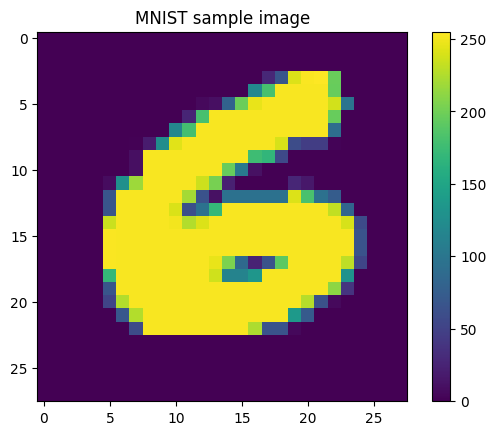

PIL.Image
min: 0, max: 255
Torch.tensor
min: 0.0, max: 1.0


In [9]:
plt.title("MNIST sample image")
cax = plt.imshow(pil_transform(image))
plt.colorbar(cax)
plt.show()

min_val, max_val = pil_transform(image).getextrema()
print(f"PIL.Image")
print(f"min: {min_val}, max: {max_val}")

print(f"Torch.tensor")
print(f"min: {torch.min(image)}, max: {torch.max(image)}")

In [10]:
batch_size = 256
num_workers = 8

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=num_workers)

In [11]:
print(len(train_dataloader))
print(len(valid_dataloader))

187
47


In [12]:
class LinearModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super().__init__()

        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        self.layers = self.get_layer()

    def get_layer(self):
        layers = nn.ModuleList()

        if self.hidden_sizes:
            layers.append(nn.Linear(self.input_size, self.hidden_sizes[0]))
            layers.append(nn.ReLU())
            if len(self.hidden_sizes) >= 2:
                for idx in range(1, len(self.hidden_sizes)):
                    layers.append(nn.Linear(self.hidden_sizes[idx-1], self.hidden_sizes[idx]))
                    layers.append(nn.ReLU())
            layers.append(nn.Linear(self.hidden_sizes[-1], self.num_classes))
        else:
            layers.append(nn.Linear(self.input_size, self.num_classes))

        return layers
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [13]:
model = LinearModel(784, [500, 300, 100], 10)

In [14]:
print(model.layers)

ModuleList(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10, bias=True)
)


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

criterion.to(device)
model.to(device)

LinearModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [17]:
epochs = 1000
lowest_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs + 1):
    model.train()
    train_loss = 0.0
    for (x, y) in train_dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        y_hat = model(x)
        
        loss = criterion(y_hat, y)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    if epoch % 100 == 0:
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for (x, y) in valid_dataloader:
                x, y = x.to(device), y.to(device)

                y_hat = model(x)
                
                loss = criterion(y_hat, y)
                valid_loss += loss.item()
            
            valid_loss /= len(valid_dataloader)
            valid_losses.append(valid_loss)

            if valid_loss < lowest_loss:
                lowest_loss = valid_loss
                torch.save(model.state_dict(), "best_model.pth")
                print(f"New best model saved at epoch {epoch} with Valid Loss: {valid_loss:.4f}")

            print(f"Epoch: {epoch}/{epochs} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")

New best model saved at epoch 0 with Valid Loss: 2.3010
Epoch: 0/1000 | Train Loss: 2.3021 | Valid Loss: 2.3010
New best model saved at epoch 100 with Valid Loss: 0.5191
Epoch: 100/1000 | Train Loss: 0.5092 | Valid Loss: 0.5191
New best model saved at epoch 200 with Valid Loss: 0.3502
Epoch: 200/1000 | Train Loss: 0.3259 | Valid Loss: 0.3502
New best model saved at epoch 300 with Valid Loss: 0.2908
Epoch: 300/1000 | Train Loss: 0.2626 | Valid Loss: 0.2908
New best model saved at epoch 400 with Valid Loss: 0.2428
Epoch: 400/1000 | Train Loss: 0.2120 | Valid Loss: 0.2428
New best model saved at epoch 500 with Valid Loss: 0.2053
Epoch: 500/1000 | Train Loss: 0.1717 | Valid Loss: 0.2053
New best model saved at epoch 600 with Valid Loss: 0.1787
Epoch: 600/1000 | Train Loss: 0.1420 | Valid Loss: 0.1787
New best model saved at epoch 700 with Valid Loss: 0.1602
Epoch: 700/1000 | Train Loss: 0.1196 | Valid Loss: 0.1602
New best model saved at epoch 800 with Valid Loss: 0.1463
Epoch: 800/1000 | 

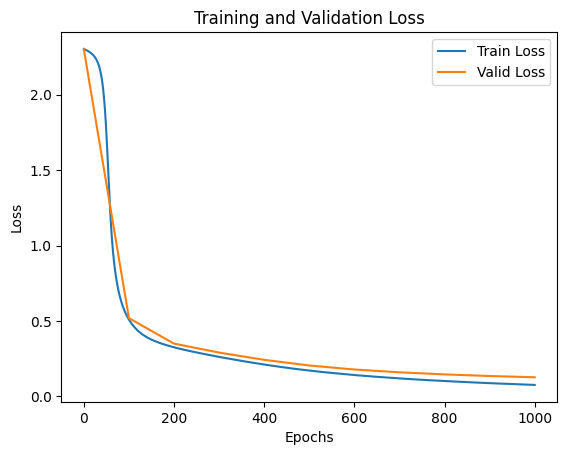

In [18]:
plt.plot(train_losses, label="Train Loss")
plt.plot(range(0, len(valid_losses) * 100, 100), valid_losses, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# With Rotation

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(0, 360)),
    transforms.Lambda(lambda x: x.view(-1)),
])

In [20]:
dataset = MNIST(root="./data", train=True, transform=transform, download=True)

In [21]:
generator = torch.Generator().manual_seed(seed)
train_dataset, valid_dataset = random_split(dataset, [0.8, 0.2], generator)

In [22]:
print(len(train_dataset))
print(len(valid_dataset))

48000
12000


In [23]:
image, label = train_dataset[0]

print(type(image))
print(image.shape)

print(type(label))
print(label)

<class 'torch.Tensor'>
torch.Size([784])
<class 'int'>
6


In [24]:
pil_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.view(-1, 28, 28)),
    transforms.ToPILImage(),
])

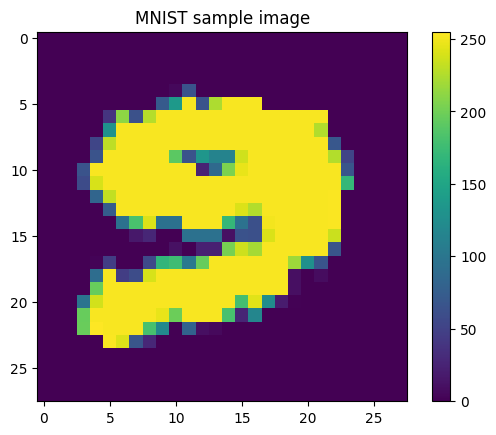

PIL.Image
min: 0, max: 255
Torch.tensor
min: 0.0, max: 1.0


In [25]:
plt.title("MNIST sample image")
cax = plt.imshow(pil_transform(image))
plt.colorbar(cax)
plt.show()

min_val, max_val = pil_transform(image).getextrema()
print(f"PIL.Image")
print(f"min: {min_val}, max: {max_val}")

print(f"Torch.tensor")
print(f"min: {torch.min(image)}, max: {torch.max(image)}")

In [26]:
batch_size = 256
num_workers = 8

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=num_workers)

In [27]:
print(len(train_dataloader))
print(len(valid_dataloader))

187
47


In [28]:
class LinearModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super().__init__()

        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        self.layers = self.get_layer()

    def get_layer(self):
        layers = nn.ModuleList()

        if self.hidden_sizes:
            layers.append(nn.Linear(self.input_size, self.hidden_sizes[0]))
            layers.append(nn.ReLU())
            if len(self.hidden_sizes) >= 2:
                for idx in range(1, len(self.hidden_sizes)):
                    layers.append(nn.Linear(self.hidden_sizes[idx-1], self.hidden_sizes[idx]))
                    layers.append(nn.ReLU())
            layers.append(nn.Linear(self.hidden_sizes[-1], self.num_classes))
        else:
            layers.append(nn.Linear(self.input_size, self.num_classes))

        return layers
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [29]:
model = LinearModel(784, [500, 300, 100], 10)

In [30]:
print(model.layers)

ModuleList(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10, bias=True)
)


In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"

criterion.to(device)
model.to(device)

LinearModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [33]:
epochs = 1000
lowest_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs + 1):
    model.train()
    train_loss = 0.0
    for (x, y) in train_dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        y_hat = model(x)
        
        loss = criterion(y_hat, y)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    if epoch % 100 == 0:
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for (x, y) in valid_dataloader:
                x, y = x.to(device), y.to(device)

                y_hat = model(x)
                
                loss = criterion(y_hat, y)
                valid_loss += loss.item()
            
            valid_loss /= len(valid_dataloader)
            valid_losses.append(valid_loss)

            if valid_loss < lowest_loss:
                lowest_loss = valid_loss
                torch.save(model.state_dict(), "best_model_with_rotation.pth")
                print(f"New best model saved at epoch {epoch} with Valid Loss: {valid_loss:.4f}")

            print(f"Epoch: {epoch}/{epochs} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")

New best model saved at epoch 0 with Valid Loss: 2.3051
Epoch: 0/1000 | Train Loss: 2.3054 | Valid Loss: 2.3051
New best model saved at epoch 100 with Valid Loss: 1.5420
Epoch: 100/1000 | Train Loss: 1.5392 | Valid Loss: 1.5420
New best model saved at epoch 200 with Valid Loss: 1.3915
Epoch: 200/1000 | Train Loss: 1.3760 | Valid Loss: 1.3915
New best model saved at epoch 300 with Valid Loss: 1.3010
Epoch: 300/1000 | Train Loss: 1.2859 | Valid Loss: 1.3010
New best model saved at epoch 400 with Valid Loss: 1.1907
Epoch: 400/1000 | Train Loss: 1.1782 | Valid Loss: 1.1907
New best model saved at epoch 500 with Valid Loss: 1.0483
Epoch: 500/1000 | Train Loss: 1.0377 | Valid Loss: 1.0483
New best model saved at epoch 600 with Valid Loss: 0.8492
Epoch: 600/1000 | Train Loss: 0.8390 | Valid Loss: 0.8492
New best model saved at epoch 700 with Valid Loss: 0.6262
Epoch: 700/1000 | Train Loss: 0.6105 | Valid Loss: 0.6262
New best model saved at epoch 800 with Valid Loss: 0.5023
Epoch: 800/1000 | 

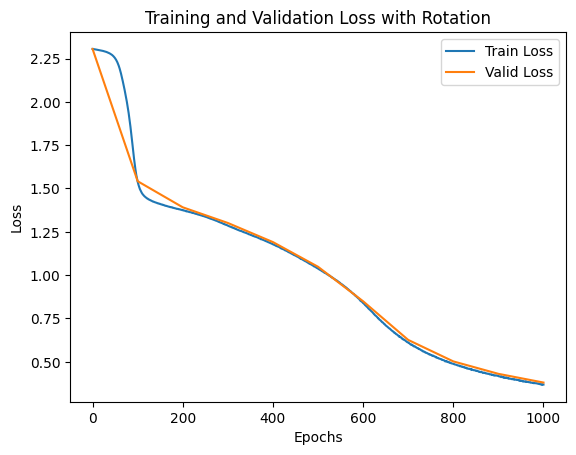

In [34]:
plt.plot(train_losses, label="Train Loss")
plt.plot(range(0, len(valid_losses) * 100, 100), valid_losses, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss with Rotation")
plt.show()